In [ ]:
import torch
from gd_env import GeometryEnv
from utils_visual import FrameStacker, render_env
from ModelHybrid import HybridAgent
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import pickle

In [ ]:

episodes = 200
batch_size = 32
stack_k = 4
input_size = (84, 84)

env = GeometryEnv()
fs = FrameStacker(k=stack_k, out_size=input_size, grayscale=True)
agent = HybridAgent(state_size=len(env.get_state()), in_channels=stack_k, action_size=2, lr=1e-4)

device = next(agent.model.parameters()).device  # 'cuda:0' o 'cpu'
agent.model.train()  

rewards_history, epsilon_history = [], []

def predict_fn(state_batch):
    state_np = np.asarray(state_batch, dtype=np.float32)

    visual_dummy = np.zeros((len(state_np), stack_k, 84, 84), dtype=np.float32)
    v = torch.from_numpy(visual_dummy).to(device=device)
    s = torch.from_numpy(state_np).to(device=device)

    with torch.no_grad():
        q_vals = agent.model(v, s).detach().cpu().numpy()  
    return q_vals

# (Opcional) background pequeño para SHAP (más rápido/estable)
background_states = np.array([env.get_state() for _ in range(32)], dtype=np.float32)
explainer = shap.Explainer(predict_fn, background_states)

shap_records = []

for e in range(episodes):
    env.reset()
    first_frame = render_env(env)
    visual = fs.reset(first_frame)
    state = env.get_state()
    total_reward = 0

    for t in range(2000):
        action = agent.act(visual, state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        frame_next = render_env(env)
        next_visual = fs.step(frame_next)

        agent.remember(visual, state, action, reward, next_visual, next_state, float(done))
        agent.replay(batch_size)

        visual, state = next_visual, next_state
        if done:
            agent.update_target_model()
            break

    rewards_history.append(total_reward)
    epsilon_history.append(agent.epsilon)
    print(f"Ep {e+1}/{episodes} | Reward={total_reward:.2f} | eps={agent.epsilon:.3f}")

    # Cada 50 episodios: pasar temporalmente a eval(), correr SHAP, luego regresar a train()
    if (e + 1) % 50 == 0:
        agent.model.eval()
        try:
            sample_state = env.get_state().reshape(1, -1)
            shap_values = explainer(sample_state)
            shap_records.append(shap_values)
            print("\n🧩 SHAP feature importance en episodio", e + 1)
            # Si quieres gráfico interactivo en notebooks: descomenta
            # shap.plots.bar(shap_values[0], show=True)
        finally:
            agent.model.train()

# Guardar modelo y SHAP
torch.save(agent.model.state_dict(), "geometry_dqn_hybrid2.pth")
print("Modelo híbrido guardado en geometry_dqn_hybrid2.pth")

with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_records, f)
print("SHAP values guardados en shap_values.pkl")

Ep 1/200 | Reward=-5.00 | eps=0.740
Ep 2/200 | Reward=4.00 | eps=0.156
Ep 3/200 | Reward=-5.00 | eps=0.094
Ep 4/200 | Reward=4.00 | eps=0.050
Ep 5/200 | Reward=-5.00 | eps=0.050
Ep 6/200 | Reward=-5.00 | eps=0.050
Ep 7/200 | Reward=-5.00 | eps=0.050
Ep 8/200 | Reward=-2.00 | eps=0.050
Ep 9/200 | Reward=-5.00 | eps=0.050
Ep 10/200 | Reward=-2.00 | eps=0.050
Ep 11/200 | Reward=-5.00 | eps=0.050
Ep 12/200 | Reward=-5.00 | eps=0.050
Ep 13/200 | Reward=-5.00 | eps=0.050
Ep 14/200 | Reward=-5.00 | eps=0.050
Ep 15/200 | Reward=-5.00 | eps=0.050
Ep 16/200 | Reward=0.00 | eps=0.050
Ep 17/200 | Reward=5.00 | eps=0.050
Ep 18/200 | Reward=0.00 | eps=0.050
Ep 19/200 | Reward=-5.00 | eps=0.050
Ep 20/200 | Reward=0.00 | eps=0.050
Ep 21/200 | Reward=-1.00 | eps=0.050
Ep 22/200 | Reward=-5.00 | eps=0.050
Ep 23/200 | Reward=-5.00 | eps=0.050
Ep 24/200 | Reward=13.00 | eps=0.050
Ep 25/200 | Reward=-5.00 | eps=0.050
Ep 26/200 | Reward=-5.00 | eps=0.050
Ep 27/200 | Reward=3.00 | eps=0.050
Ep 28/200 | Rewar

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# rewards_history = [
#     7, -2, -1, -5, 10, 18, -3, 5, 8, -5, -5, -5, -5, -5, 10, -3, 8, -2, -5, -5,
#     19, -5, -5, 16, 12, 10, -5, -5, 8, 15, -5, -5, -5, 21, 14, 13, -5, 10, 37, -5,
#     10, 18, 13, -5, -5, -5, -5, -5, -5, -5, 14, -2, -5, -5, -5, 7, 16, -5, 10, -5,
#     18, -5, -5, 12, -5, 18, 73, -5, 9, -5, 11, -5, 48, -5, 146, 50, -2, -5, 9, -2,
#     -5, -5, -5, -5, -5, 49, -1, 65, 2, 150, 17, -1, -2, 5, 38, 35, -5, 133, 139, 5,
#     144, 124, 145, 113, 128, 123, 17, 136, 49, 39, 31, 120, 126, 32, 75, 112, 139,
#     38, 136, 126, 7, 31, 127, 15, 31, 70, -2, 7, -5, 113, 36, -2, 124, 46, 132, 136,
#     66, 54, 13, 101, 136, 100, 36, -5, 156, 121, 144, 13, 11, 125, 35, 126, 144, 37,
#     152, 23, 136, -5, -5, 142, 132, 135, 139, 136, 73, 119, 29, 31, 138, 37, 118, 142,
#     129, -1, 159, 153, 133, 148, 132, 145, 140, 66, 122, 25, 43, 27, -5, 27, 135, -5,
#     11, 144, 108, 138, 147, 140, 145, 25, -5, 125
# ]

# epsilon_history = [
#     0.576, 0.344, 0.212, 0.127, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050,
#     0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050, 0.050
# ]


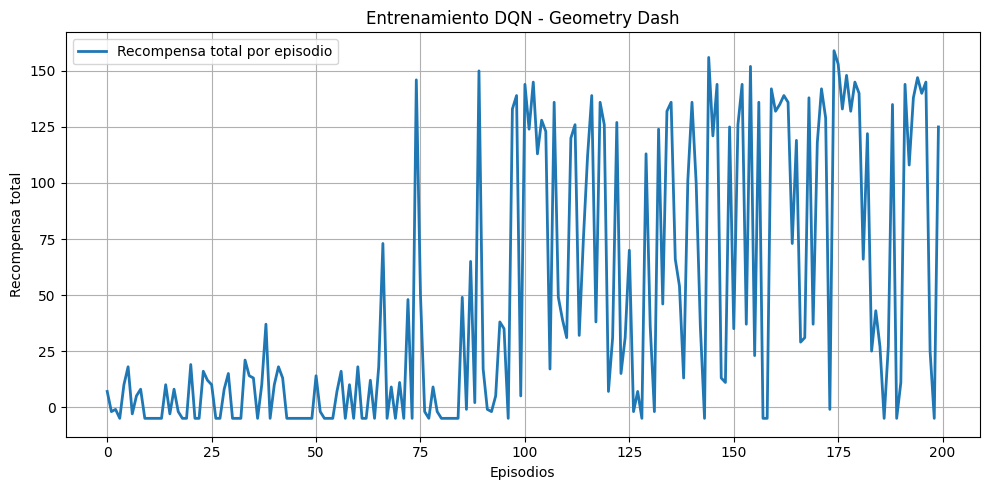

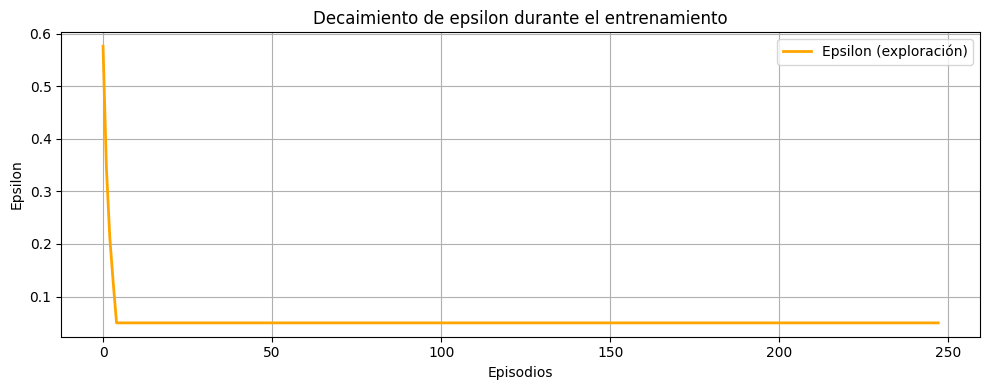

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="Recompensa total por episodio", linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Recompensa total")
plt.title("Entrenamiento DQN - Geometry Dash")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epsilon_history, color="orange", label="Epsilon (exploración)", linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Epsilon")
plt.title("Decaimiento de epsilon durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

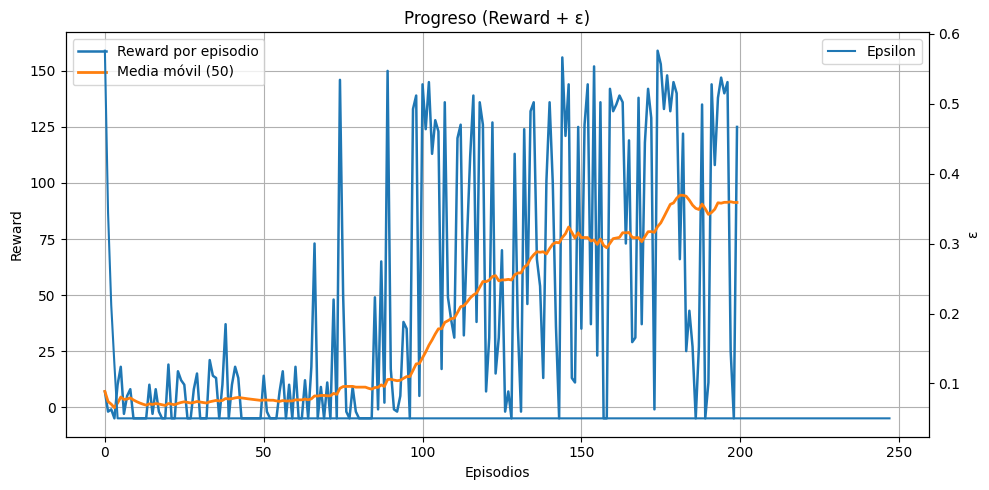

In [ ]:
from collections import deque

def moving_avg(seq, w=50):
    out, q, s = [], deque(), 0.0
    for v in seq:
        q.append(v); s += v
        if len(q) > w:
            s -= q.popleft()
        out.append(s/len(q))
    return out

# Gráfico extra: reward con media móvil + epsilon en eje secundario
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(rewards_history, label="Reward por episodio", linewidth=1.8)
ma = moving_avg(rewards_history, w=50)
if len(ma) == len(rewards_history):
    ax1.plot(ma, label="Media móvil (50)", linewidth=2)
ax1.set_xlabel("Episodios"); ax1.set_ylabel("Reward")
ax1.grid(True); ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(epsilon_history, label="Epsilon", linewidth=1.5)
ax2.set_ylabel("ε")
ax2.legend(loc="upper right")
plt.title("Progreso (Reward + ε)")
plt.tight_layout()
plt.show()
